<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means Clustering

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

## Generate Data

In [10]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
#print("Path to dataset files:", dataset_path)

support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

Using Colab cache for faster access to the 'support-ticket-priority-dataset-50k' dataset.


In [34]:
# --- 1. ВИЗНАЧЕННЯ ОЗНАК (КОРЕКТНИЙ НАБІР) ---
# ЧИСЛОВІ ОЗНАКИ (для масштабування)
numerical_features = [
    #'day_of_week_num',
    'customers_affected'
]
# КАТЕГОРІАЛЬНІ ОЗНАКИ (для One-Hot Encoding)
categorical_features = [
    'company_size_cat',  'region_cat',
    'customer_tier_cat'
]
# ЦІЛЬОВА ЗМІННА
y_text = support_ticket_data['priority_cat']

# --- 2. СТВОРЕННЯ ЦІЛЬОВОЇ ЗМІННОЇ (y) ---
le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium']
colors = ['tab:red', 'tab:green', 'tab:blue'] # Кольори для 3 класів


# --- 3. КОНВЕЄР ДЛЯ ОБРОБКИ ОЗНАК ---
preprocessor = ColumnTransformer(
    transformers=[
        # A. Обробка ЧИСЛОВИХ: Заповнення NaN (середнім) + Масштабування
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),

        # B. Обробка КАТЕГОРІАЛЬНИХ: One-Hot Encoding
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)

# Створення вихідної матриці X та її обробка
X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")

Матриця X_scaled успішно створена. Розмірність: (50000, 10)


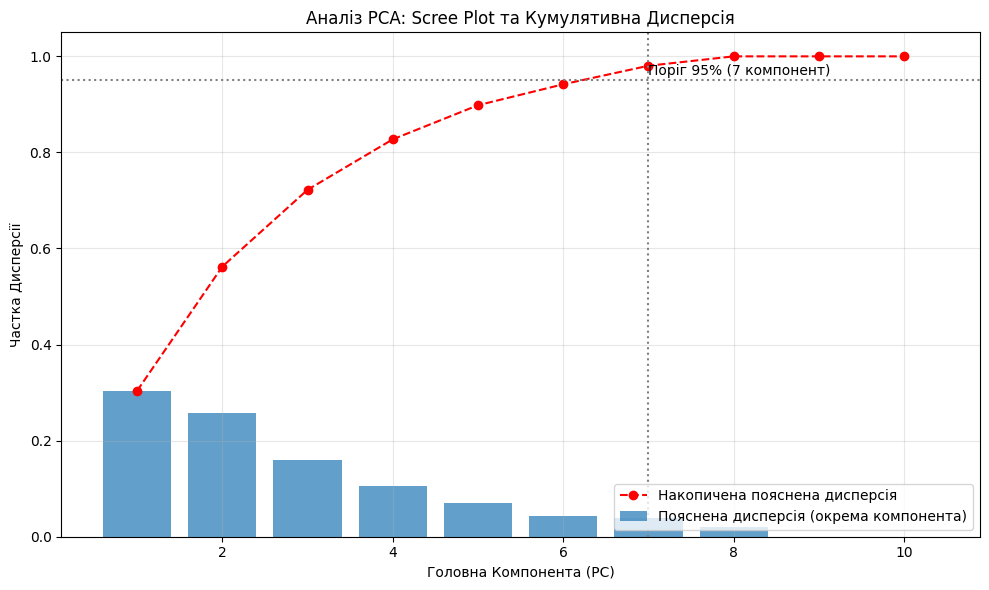


Оптимальна k для 95% дисперсії: 7


In [35]:
# --- 1. РОЗРАХУНОК PCA З НУЛЯ (FROM SCRATCH) ---
n = X_scaled.shape[0]

# 1. Обчислення коваріаційної матриці
cov_mat = (X_scaled.T @ X_scaled) / (n - 1)

# 2. Ейгенрозклад
eigvals, eigvecs = np.linalg.eigh(cov_mat)

# 3. Сортування результатів у ЗСПАДАЮЧОМУ порядку
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
# eigvecs = eigvecs[:, order] # Не потрібні для Scree Plot

# --- 2. АНАЛІЗ ДИСПЕРСІЇ ---
explained_variance_ratio = eigvals / eigvals.sum()
evr = explained_variance_ratio
cum_evr = np.cumsum(evr)
n_components = len(evr)

# Визначаємо кількість компонент для 95% дисперсії
n_components_95 = np.argmax(cum_evr >= 0.95) + 1

# --- 3. Scree Plot ---
plt.figure(figsize=(10, 6))

plt.bar(range(1, n_components + 1), evr, alpha=0.7, label='Пояснена дисперсія (окрема компонента)')
plt.plot(range(1, n_components + 1), cum_evr, marker='o', color='red',
         linestyle='--', label='Накопичена пояснена дисперсія')

plt.axhline(0.95, linestyle=':', linewidth=1.5, color='gray')
plt.text(n_components * 0.7, 0.955, f'Поріг 95% ({n_components_95} компонент)',
         va='bottom', color='black', fontsize=10)
plt.axvline(n_components_95, color='gray', linestyle=':', linewidth=1.5)

plt.xlabel('Головна Компонента (PC)')
plt.ylabel('Частка Дисперсії')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.title('Аналіз PCA: Scree Plot та Кумулятивна Дисперсія')
plt.tight_layout()
plt.show()

print(f"\nОптимальна k для 95% дисперсії: {n_components_95}")

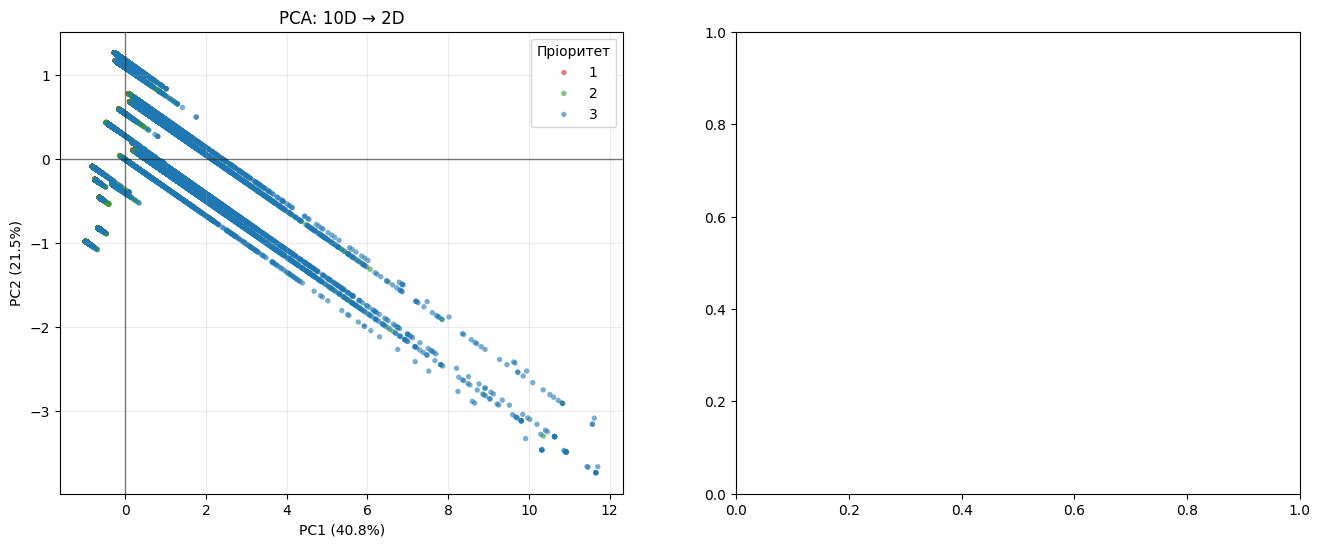

In [36]:
from sklearn.manifold import TSNE

# --- 1. PCA 14D → 2D для Візуалізації ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pc1, pc2 = X_pca[:, 0], X_pca[:, 1]
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]

# --- 2. t-SNE 14D → 2D для Візуалізації ---
# Створюємо невелику вибірку, оскільки t-SNE повільний
sample_size = 5000
np.random.seed(42)
total_samples = X_scaled.shape[0]
sample_indices = np.random.choice(total_samples, size=sample_size, replace=False)

X_sample = X_scaled[sample_indices]
y_sample_encoded = y_encoded[sample_indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sample)
tsne1, tsne2 = X_tsne[:, 0], X_tsne[:, 1]

# --- 3. ВІЗУАЛІЗАЦІЯ ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
n_classes = len(priorities)
y = y_encoded

# Графік PCA
ax = axes[0]
for cls, name, c in zip(range(n_classes), priorities, colors):
    idx = (y == cls)
    ax.scatter(pc1[idx], pc2[idx], label=name, c=c, s=15, edgecolor='none', alpha=0.6)
ax.axhline(0, linewidth=1, color='black', alpha=0.5)
ax.axvline(0, linewidth=1, color='black', alpha=0.5)
ax.set_xlabel(f'PC1 ({explained_variance_pc1*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance_pc2*100:.1f}%)')
ax.set_title(f'PCA: {X_scaled.shape[1]}D → 2D')
ax.legend(title="Пріоритет")
ax.grid(True, alpha=0.25)


In [24]:
# Використовуємо оптимальну k, знайдену на Scree Plot (наприклад, 95% -> 9 компонент)
# Замініть 9 на значення, яке ви отримали на своєму графіку Scree Plot!
optimal_k = 9

# 1. Розбиття на вибірки
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

# --- A. Система 1: Навчання на повних даних (14D) ---
model_full = LogisticRegression(max_iter=1000, random_state=42)
start_time_full = time.time()
model_full.fit(X_train_full, y_train)
time_full = time.time() - start_time_full
accuracy_full = model_full.score(X_test_full, y_test)

# --- B. Система 2: Навчання на зменшених даних (k=9D) ---
pca_optimized = PCA(n_components=optimal_k, random_state=42)
X_train_pca = pca_optimized.fit_transform(X_train_full)
X_test_pca = pca_optimized.transform(X_test_full)

model_pca = LogisticRegression(max_iter=1000, random_state=42)
start_time_pca = time.time()
model_pca.fit(X_train_pca, y_train)
time_pca = time.time() - start_time_pca
accuracy_pca = model_pca.score(X_test_pca, y_test)

# --- 3. ВИСНОВКИ ---
print("\n--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---")
print(f"Початкова розмірність: {X_scaled.shape[1]}D")
print(f"PCA розмірність: {optimal_k}D (Збережено 95% дисперсії)")
print("----------------------------------------------------------------------")
print(f"1. Повні дані (14D): Точність={accuracy_full:.4f}, Час={time_full:.4f} сек")
print(f"2. Зменшені дані (9D): Точність={accuracy_pca:.4f}, Час={time_pca:.4f} сек")
print("----------------------------------------------------------------------")
print(f"Зміна точності: {accuracy_pca - accuracy_full:.4f}")
print(f"Прискорення навчання: {time_full / time_pca:.1f} разів")


--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---
Початкова розмірність: 18D
PCA розмірність: 9D (Збережено 95% дисперсії)
----------------------------------------------------------------------
1. Повні дані (14D): Точність=0.6817, Час=0.7904 сек
2. Зменшені дані (9D): Точність=0.6799, Час=0.3566 сек
----------------------------------------------------------------------
Зміна точності: -0.0018
Прискорення навчання: 2.2 разів
